In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
import importlib

import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

from itertools import product
from pandas_profiling import ProfileReport

from criteriaetl.utils.expansion_func import (get_value_counts_with_expansion_factor,
    get_percentage_table_with_expansion_factor)
from criteriaetl.utils.display_func import cdisplay, percentage_count_plot
from criteriaetl.utils.common_func import (get_weighted_complete_randomization_series_on_subset, 
    proportional_cut, weighted_qcut, get_partition_bool_columns_dict)
from criteriaetl.transformers.columns_base import (NameTransformer, 
    ReplaceTransformer, SelectTransformer, AssignTransformer)
from criteriaetl.transformers.rows_base import AggregateTransformer
from criteriaetl.transformers.fusion_base import MergeTransformer

from projectetl.utils.dataload import (load_survey_data_do, save_survey_with_pickle,
                                       load_survey_from_pickle)
from projectetl.utils.config import ENHOGAR_DIR

In [8]:
survey_elected_raw = load_survey_data_do(ENHOGAR_DIR / 'Elegidos_ENHOGAR2016_PUB.sav',
                                         load_func=lambda path: pd.read_spss(str(path)))
survey_member_raw = load_survey_data_do(ENHOGAR_DIR / 'Personas_ENHOGAR2016_PUB.sav',
                                        load_func=lambda path: pd.read_spss(str(path)))
survey_house_raw = load_survey_data_do(ENHOGAR_DIR / 'Viviendas_ENHOGAR2016_PUB.sav',
                                       load_func=lambda path: pd.read_spss(str(path)))

In [9]:
# hhogar 
# ---
# h402 = sexo
# h403 = edad
# h405 = parentesco
# h407 = estado civil (h407a = números)
# ----
# h409 = aprendió a leer y escribir
# h410 = donde aprendió a leer y escribir
# h411 = asiste o asistió a centro educativo
# h412 = nivel educativo más alto
# h413 = curso o año más alto que cursó
# h414 = asiste en el actual año escolar a algún centro educativo
# h415 = nivel educativo al que está asistiendo
# h416 = curso o año al que está asistiendo
# ---
# h501 = ¿Trabajó o realizó (nombre) alguna actividad económica por lo menos una hora la semana pasada?
# h502 = Aunque no trabajó la semana pasada ¿Tenía algún empleo, negocio o actividad?
# h503 = ¿La semana pasada (nombre) cultivó, cosechó o cuidó ganado u otros animales?
# h504 = ¿La semana pasada, elaboró (nombre) algún producto como artesanía o comida para vender?
# h505 = ¿La semana pasada, ayudó (nombre) a algún familiar en su negocio, empresa o finca?
# h506 = ¿La semana pasada (nombre) cosió, planchó, limpió casas, lavó ropa ajena o realizó otra actividad por paga?
# h507 = Durante las últimas cuatro semanas ¿Ha buscado (nombre) trabajo o estuvo tratando de establecer su propio negocio, actividad económica o empresa?
# h508 = ¿Por qué (nombre) no ha buscado trabajo?
# lh509 = ¿Podría (nombre) haber aceptado un trabajo la semana pasada si le hubieran ofrecido uno?
# lh510 = ¿Dispone (nombre) del tiempo y las condiciones necesarias para salir a trabajar?
# lh511 = La semana pasada, ¿Habría tenido (nombre) el tiempo y las condiciones necesarias para salir a trabajar?
# lh512 = ¿Ha trabajado (nombre) antes por paga o ganancia?
# lh513 = ¿Cuál fue la principal ocupación u oficio línea que desempeñó (nombre) durante la semana pasada o en el último trabajo que tuvo?
# lh514 = ¿A qué se dedica la empresa, negocio o institución en la que trabaja (nombre) actualmente o trabajó por última vez?
# lh515 = ¿En ese trabajo (nombre) es o era...
# lh516 = Regularmente, ¿Cuántas horas a la semana trabaja o trabajó (nombre) en su ocupación principal?
# h601 = ¿Tiene (nombre) PREG. algún seguro de salud, seguro médico o plan de salud?
# region
member_columns = [
    # Identifiers
    'hhogar', 'hzona', 'hprovi', 'h402', 'h403', 'h405', 'h407',
    # Education
    'h409', 'h410', 'h411', 'h412', 'h413', 'h414',
    'h415', 'h416',
    # Economic characteristics
    'h501', 'h502', 'h503', 'h504', 'h505', 'h506', 
    'h507', 'h508', 'lh509', 'lh510', 'lh511', 'lh512', 'lh513',
    'lh514', 'lh515', 'lh516',
    # Assurance
    'h601',
    # Stratos
    'hestrat', 'region', 'grupsec', 'zona', 'hmiembro',
    'hprovin', 'estratos',
    # Factors
    'fexpansion', 'fponderacion'
]

# h702a = Número de personas estándar mayores de 10 en el hogar
# h704 = edad
# h1001 = ¿Trabajó usted la semana pasada por paga o ganacia?
# h1002 = ¿Cuántos días trabajó usted durante la semana pasada?
# h1003 = ¿Cuántas horas trabajó usted diariamente la semana pasada?
# h1005 = ¿Estudia usted actualmente?
# h1009 = ¿Realiza usted algún tipo de estudio vocacional, técnico o profesional como música, pintura, computación u otra actividad similar?
# h1015 = Durante la semana pasada ¿Dedicó usted algún tiempo al cuidado de enfermos, ancianos, niños u otras personas, ya sean de su hogar u otro hogar?
# h1016 = Durante la semana pasada ¿Cuántos días le dedico al cuidado de esa o esas personas?
# h1017 = Durante la semana pasada ¿Cuántas horas le dedicó usted al cuidado de esa o esas personas diariamente o el último día que cuidó a esa o esas personas?
# h1030 = En la semana pasada, ¿Cuántos días dedicó usted tiempo para criar o cuidar animales o realizar algún cultivo o cosecha de productos para el consumo del hogar?
# h1032 = Durante la semana pasada, ¿Cuántos días dedicó usted a realizar algún trabajo sin paga en un negocio o establecimiento de comercio o producción?
# h1034 = En la semana pasada, ¿Cuántos días dedicó usted tiempo para realizar actividades domésticas en su hogar, como limpiar la casa, cocinar, lavar, fregar u otras labores domésticas?
# h1035 = En la semana pasada, ¿Cuántas horas dedicó usted a realizar actividades diariamente o el último día que las realizó la semana pasada?
# h1036 = En la semana pasada, ¿Cuántos días dedicó usted tiempo para realizar actividades domésticas sin paga en otro hogar, como limpiar la casa, cocinar, lavar, fregar u otras labores domésticas?
# h1037 = Durante la semana pasada, ¿Cuántas horas dedicó usted a realizar esas actividades diariamente o el último día que las ralizó la semana pasada?
elected_columns = [
    'h703', 'h702a',
    'h704', 'h1001', 'h1002', 'h1003', 'h1005',
    'h1009', 'h1030', 'h1032',
    'fexpansion_tic', 'fponderacion_tic',
    # Target
    'h1015', 'h1016', 'h1017', 'h1034', 'h1035',
    'h1036', 'h1037'
]

# Processing surveys

In [10]:
basic_cols = [
    'hhupm', 'hhviv', 'hhogar'
]

## Assign Transformer

In [11]:
assign_member_map = {
    'temp': lambda _: 1,
    'h703': lambda df, cols=basic_cols: df.groupby(cols)['temp'].transform('cumsum')
}

assign_member_transformer = AssignTransformer(assign_member_map)
survey_member_assigned = assign_member_transformer.transform(survey_member_raw)

In [12]:
survey_member_assigned.head()

,hhupm,hhviv,hhogar,zona,hprovi,hmiembro,h402,h403,h404d,h404m,...,h632,hzona,hprovin,estratos,region,grupsec,fexpansion,fponderacion,temp,h703
0,1.0,1.0,1.0,Urbano,Distrito Nacional,6.0,Hombre,41.0,13.0,12.0,...,No,Urbano,Distrito Nacional,Ciudad de Santo Domingo,Metropolitana,Medio bajo,143.43477,1.080379,1,1
1,1.0,1.0,1.0,Urbano,Distrito Nacional,6.0,Mujer,33.0,29.0,9.0,...,No,Urbano,Distrito Nacional,Ciudad de Santo Domingo,Metropolitana,Medio bajo,143.43477,1.080379,1,2
2,1.0,1.0,1.0,Urbano,Distrito Nacional,6.0,Mujer,18.0,11.0,3.0,...,No,Urbano,Distrito Nacional,Ciudad de Santo Domingo,Metropolitana,Medio bajo,143.43477,1.080379,1,3
3,1.0,1.0,1.0,Urbano,Distrito Nacional,6.0,Hombre,14.0,23.0,12.0,...,No,Urbano,Distrito Nacional,Ciudad de Santo Domingo,Metropolitana,Medio bajo,143.43477,1.080379,1,4
4,1.0,1.0,1.0,Urbano,Distrito Nacional,6.0,Hombre,11.0,13.0,9.0,...,No,Urbano,Distrito Nacional,Ciudad de Santo Domingo,Metropolitana,Medio bajo,143.43477,1.080379,1,5


## Merge Transformer

In [13]:
merge_member_elected_transformer = MergeTransformer(lambda : survey_member_assigned,
                                                    merge_kwargs={
                                                        'on': basic_cols + ['h703'],
                                                        'suffixes': ('', '_other')
                                                    })
survey_elected_merged = merge_member_elected_transformer.transform(survey_elected_raw)

In [14]:
survey_elected_merged = survey_elected_merged[member_columns + elected_columns]

## Name Transformer

In [58]:
name_elected_map = {
    'h402': 'sexo',
    'h403': 'edad',
    'h405': 'parentesco',
    'h407': 'estado_civil',
    'h409': 'aprendio_leer_escribir',
    'h410': 'donde_aprendio_leer_escribir',
    'h411': 'asiste_asistio_centro_educativo',
    'h412': 'nivel_educativo_mas_alto',
    'h413': 'curso_mas_alto_que_curso',
    'h414': 'asiste_centro_educativo_actualmente',
    'h415': 'nivel_esta_asistiendo',
    'h416': 'curso_esta_asistiendo',
    'h501': 'trabajo_semana_pasada',
    'h502': 'tenia_empleo_semana_pasada',
    'h503': 'cultivo_cosecho_semana_pasada',
    'h504': 'elaboro_producto_semana_pasada',
    'h505': 'ayudo_familiar_semana_pasada',
    'h506': 'tuvo_trabajo_domestico_por_paga_semana_pasada',
    'h507': 'busco_trabajo_cuatro_semanas_pasadas',
    'h508': 'motivo_no_busca_trabajo',
    'lh509': 'podria_aceptar_trabajo_semana_pasada',
    'lh510': 'dispone_condiciones_para_trabajar',
    'lh511': 'dispone_condiciones_para_trabajar_semana_pasada',
    'lh512': 'ha_trabajado_por_paga',
    'lh513': 'ultima_principal_ocupacion',
    'lh514': 'se_dedica_ultima_empresa',
    'lh515': 'ocupacion_ultimo_trabajo',
    'lh516': 'horas_trabajadas_semanalmente_ocupacion_principal',
    'h601': 'tiene_seguro_salud_pension',
    'h702a': 'mayores_10_annos',
    'h704': 'edad_elegido',
    'h1001': 'trabajo_por_paga_semana_pasada',
    'h1002': 'dias_trabajo_semana_pasada',
    'h1003': 'horas_trabajo_semana_pasada',
    'h1005': 'estudia_actualmente',
    'h1009': 'realiza_actividad_vocacional',
    'h1015': 'dedico_tiempo_cuidados',
    'h1016': 'tiempo_cuidados_dias',
    'h1017': 'tiempo_cuidado_horas_diarias',
    'h1030': 'tiempo_agricultura_ganado_dias',
    'h1032': 'tiempo_trabajo_sin_paga_dias',
    'h1034': 'tiempo_trabajo_domestico_hogar_dias',
    'h1035': 'tiempo_trabajo_domestico_hogar_horas',
    'h1036': 'tiempo_trabajo_domestico_no_hogar_dias',
    'h1037': 'tiempo_trabajo_domestico_no_hogar_horas'
}

keep = ['hhogar', 'hzona', 'hprovi',
        # Stratos
        'hestrat', 'region', 'grupsec', 'zona', 'hmiembro',
        'hprovin', 'estratos',
        # Factors
        'fexpansion', 'fponderacion',
        'fexpansion_tic', 'fponderacion_tic',]

name_elected_transformer = NameTransformer(name_elected_map, keep_features=keep)
survey_elected_named = name_elected_transformer.transform(survey_elected_merged)

In [26]:
survey_elected_named['region'].unique()

['Metropolitana', 'Cibao Norte', 'Cibao Sur', 'Cibao Nordeste', 'Cibao Noroeste', 'Valdesia', 'El Valle', 'Enriquillo', 'Higuamo', 'Del Yuma']
Categories (10, object): ['Metropolitana', 'Cibao Norte', 'Cibao Sur', 'Cibao Nordeste', ..., 'El Valle', 'Enriquillo', 'Higuamo', 'Del Yuma']

## Replace Transformer

In [59]:
replace_elected_map = {
    'sexo': {
        'Hombre': 0,
        'Mujer': 1
    },
    'estado_civil': {
        'Soltero(a)': 1,
        'Unido(a)': 2,
        'Separado(a) de unión libre': 2,
        'Viudo(a)': 4,
        'Casado(a)': 5,
        'Separado de matrimonio legal o religioso': 6,
        'Divorciado(a)': 7,
        9.0: 9
    },
    'nivel_educativo_mas_alto': {
        'Básico o Primario': 1,
        'Universitario': 2,
        'Medio o Secundario': 3,
        'Postgrado, Maestría o Doctorado': 4,
        'Sin información': 5,
        'Inicial o pres-escolar': 6,
        'No sabe': 9,
    },
    'hzona': {
        'Urbano': 0,
        'Rural': 1
    },
    'grupsec': {
        'Muy bajo': 1, 
        'Bajo': 2,
        'Medio bajo': 3, 
        'Medio y Medio alto': 4,
        'Alto': 5
    },
    'region': {
        'Metropolitana': 1,
        'Cibao Norte': 2,
        'Cibao Sur': 3,
        'Cibao Nordeste': 4,
        'Cibao Noroeste': 5,
        'Valdesia': 6,
        'El Valle': 7,
        'Enriquillo': 8,
        'Higuamo': 9,
        'Del Yuma': 10
    }
}

replace_elected_transformer = ReplaceTransformer(replace_elected_map)
survey_elected_replaced = replace_elected_transformer.transform(survey_elected_named)
survey_elected_replaced[replace_elected_map.keys()]

,sexo,estado_civil,nivel_educativo_mas_alto,hzona,grupsec,region
0,0,1.0,1.0,0,3,1
1,0,2.0,1.0,0,1,1
2,1,2.0,2.0,0,4,1
3,1,4.0,1.0,0,4,1
4,1,1.0,3.0,0,3,1
...,...,...,...,...,...,...
23256,1,2.0,1.0,1,2,10
23257,1,2.0,1.0,1,1,10
23258,1,2.0,5.0,1,2,10
23259,1,2.0,1.0,1,1,10


## Select Transformer

In [40]:
age_groups = [(10, 14), (15, 24), (25, 45), (46, 59), (60, 74), (75, 96)]

In [77]:
cols = ['trabajo_semana_pasada', 'tuvo_trabajo_domestico_por_paga_semana_pasada', 'motivo_no_busca_trabajo', 'tenia_empleo_semana_pasada',
'busco_trabajo_cuatro_semanas_pasadas']
survey_elected_replaced[cols]


,trabajo_semana_pasada,tuvo_trabajo_domestico_por_paga_semana_pasada,motivo_no_busca_trabajo,tenia_empleo_semana_pasada,busco_trabajo_cuatro_semanas_pasadas
0,No,No,Está estudiando,No,No
1,Sí,NaN,NaN,NaN,NaN
2,No,No,NaN,No,Sí
3,No,No,Por razones de edad,No,No
4,No,No,Por razones de edad,No,No
...,...,...,...,...,...
23256,Sí,NaN,NaN,NaN,NaN
23257,Sí,NaN,NaN,NaN,NaN
23258,Sí,NaN,NaN,NaN,NaN
23259,Sí,NaN,NaN,NaN,NaN


In [79]:
select_elected_map = {
    'grupo_etareo': {
        lambda df: df['edad'] == '97+': 6,
        lambda df: df['edad'] == 'No sabe': 9,
        lambda df: df['edad'] == 'Sin información': 9,
        **{
            lambda df, min_group=min_group, max_group=max_group: pd.to_numeric(df['edad'], errors='coerce').isin(range(min_group, max_group + 1)):
                lambda _, i=i: i
            for i, (min_group, max_group) in enumerate(age_groups)
        }
    },

    'condicion_actividad_bid': {
        # ocupados: 
        # trabajo_semana_pasada - realizo algun trabajo la semana anterior por lo menos una hora: sí, o
        # tuvo_trabajo_domestico_por_paga_semana_pasada - en la semana anterior: realizo alguna actividad para 
        # obtener dinero o especies, o,
        # tenia_empleo_semana_pasada - tiene un negocio o empresa a la que proximamente volverá: sí, o
        # motivo_no_busca_trabajo - da una razon por la que no trabajó
        lambda df: (df['trabajo_semana_pasada'] == 'Sí') \
                    | (df['tuvo_trabajo_domestico_por_paga_semana_pasada'] == 'Sí') \
                    | (df['tenia_empleo_semana_pasada'] == 'Sí') \
                    | ((df['trabajo_semana_pasada'] == 'No') & ~(df['motivo_no_busca_trabajo'].isna())): 1,

        # desocupados
        # busco_trabajo_cuatro_semanas_pasadas - en las 4 semanas anteriores estuvo buscando trabajo o 
        # tratando de emprender: si, y
        # r408 - en las cuantro semanas efectivamente hizo algo para 
        # buscar trabajo o emprender
        lambda df: df['busco_trabajo_cuatro_semanas_pasadas'] == 'Sí': 2,

        # inactivos
        'default': 3
    },
}

select_elected_transformer = SelectTransformer(select_elected_map)
survey_elected_selected = select_elected_transformer.transform(survey_elected_replaced)

In [80]:
survey_elected_selected

,sexo,edad,parentesco,estado_civil,aprendio_leer_escribir,donde_aprendio_leer_escribir,asiste_asistio_centro_educativo,nivel_educativo_mas_alto,curso_mas_alto_que_curso,asiste_centro_educativo_actualmente,...,zona,hmiembro,hprovin,estratos,fexpansion,fponderacion,fexpansion_tic,fponderacion_tic,grupo_etareo,condicion_actividad_bid
0,0,14.0,Adoptado/ hijo de crianza,1.0,Sí,Escuela o colegio,Sí asiste,1.0,8.0,Sí,...,Urbano,6.0,Distrito Nacional,Ciudad de Santo Domingo,143.43477,1.080379,346.88577,0.965224,0,1
1,0,24.0,El (la) Jefe(a),2.0,No,NaN,"No asiste, pero asistió",1.0,1.0,No,...,Urbano,3.0,Distrito Nacional,Ciudad de Santo Domingo,143.43477,1.080379,346.88577,0.965224,1,1
2,1,40.0,Hijo(a),2.0,Sí,Escuela o colegio,"No asiste, pero asistió",2.0,2.0,No,...,Urbano,4.0,Distrito Nacional,Ciudad de Santo Domingo,143.43477,1.080379,346.88577,0.965224,2,2
3,1,86.0,El (la) Jefe(a),4.0,No,NaN,"No asiste, pero asistió",1.0,1.0,No,...,Urbano,3.0,Distrito Nacional,Ciudad de Santo Domingo,143.43477,1.080379,346.88577,0.965224,5,1
4,1,17.0,Hijo(a),1.0,Sí,Escuela o colegio,"No asiste, pero asistió",3.0,4.0,No,...,Urbano,5.0,Distrito Nacional,Ciudad de Santo Domingo,143.43477,1.080379,346.88577,0.965224,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23256,1,18.0,Hijo(a),2.0,Sí,Escuela o colegio,"No asiste, pero asistió",1.0,8.0,No,...,Rural,6.0,El Seibo,Rural,293.70175,2.212220,317.18552,0.882582,1,1
23257,1,25.0,El (la) Jefe(a),2.0,Sí,Escuela o colegio,"No asiste, pero asistió",1.0,7.0,No,...,Rural,3.0,El Seibo,Rural,293.70175,2.212220,317.18552,0.882582,2,1
23258,1,72.0,El (la) Jefe(a),2.0,No,NaN,9.0,5.0,99.0,No,...,Rural,3.0,El Seibo,Rural,293.70175,2.212220,317.18552,0.882582,4,1
23259,1,16.0,Esposo(a) o compañero(a),2.0,Sí,Escuela o colegio,"No asiste, pero asistió",1.0,8.0,No,...,Rural,2.0,El Seibo,Rural,293.70175,2.212220,317.18552,0.882582,1,1


# EDA

## Pandas profiling

In [75]:
report = ProfileReport(survey_elected_selected, config_file='config.yml')

In [16]:
report.to_file('report.html')

Summarize dataset:   0%|          | 0/69 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation

<AxesSubplot:>

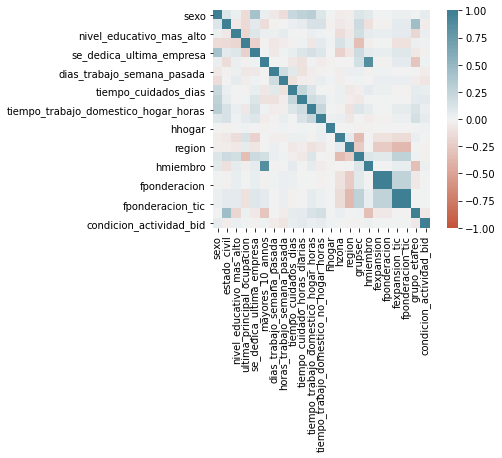

In [81]:
sns.heatmap(survey_elected_selected.corr(), vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

## Interactions

## Extra checks

In [24]:
(survey_elected_final['dedico_tiempo_cuidados'] == 'Si').sum()

5953

In [22]:
survey_elected_final.loc[survey_elected_final['dedico_tiempo_cuidados'] == 'Si', 'tiempo_cuidado_horas_diarias']

4        3.0
6        8.0
7        1.0
15       5.0
16       5.0
        ... 
23235    0.5
23240    1.0
23242    5.0
23257    4.0
23259    3.0
Name: tiempo_cuidado_horas_diarias, Length: 5953, dtype: float64

In [20]:
survey_elected_final.loc[survey_elected_final['dedico_tiempo_cuidados'] == 'Si', 'tiempo_cuidados_dias']

4        7.0
6        7.0
7        7.0
15       7.0
16       1.0
        ... 
23235    7.0
23240    2.0
23242    1.0
23257    7.0
23259    7.0
Name: tiempo_cuidados_dias, Length: 5953, dtype: float64

# Estimator